In [ ]:
NAME_MAP = {
    'CodeLlama-7b-Instruct-hf' : 'CodeLlama 7B',
    'CodeLlama-13b-Instruct-hf' : 'CodeLlama 13B',
    'CodeLlama-34b-Instruct-hf' : 'CodeLlama 34B',
    'gpt-3.5-turbo' : 'GPT-3.5',
    'gpt-4-turbo' : 'GPT-4',
    'human_written' : 'human'
}

ASPECTS_NAMES = {
    'CA' : 'Content Adequacy',
    'Conciseness' : 'Conciseness',
    'Fluency' : 'Fluency & Understandability',
}

MODEL_NAMES = ['CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo']
ASPECTS = ['CA', 'Conciseness', 'Fluency']
LANGUAGE = 'python' # python or java
PROMPT = 'zeroshot' # 'zeroshot' or 'zeroshot_instructions' or 'automatedCoT' or 'automatedCoT_instructions'

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import data

In [ ]:
# import sheets of manual analysis
df_dict = {}
csdf = pd.read_csv(f'../../code_summarization_benchmark/CS-benchmark-{LANGUAGE.capitalize()}.csv')\
    [['target_id','target','generated_by','summary','summary_postprocessed','CA_1','Conciseness_1','Fluency_1','CA_2','Conciseness_2','Fluency_2','CA_3','Conciseness_3','Fluency_3']].fillna('-')

# import LLM judgments
for model_name in MODEL_NAMES:
    df = pd.read_csv(f'../../data/code_summarization/{LANGUAGE}/{PROMPT}/{model_name}_CCF_clean.csv')
    df.index = range(df.shape[0])

    model_judgment_cols = [x for x in df.columns if model_name in x]
    for col in model_judgment_cols:
        df[col] = df[col].apply(lambda x : int(x) if x != '-' else 0)
    
    # if the model failed to generate the rating for at least one aspect (ie, CA = 0), then also the other two aspects become 0 (ie, the judgment is not valid)
    df[model_judgment_cols] = df[model_judgment_cols].apply(lambda row: 0 if row.min() == 0 and row.sum() > 0 else row, axis = 1)
    
    csdf = pd.concat([csdf, df[model_judgment_cols]], axis = 1)


# evaluating mean and median of human ratings
csdf['CA_mean'] = csdf[['CA_1', 'CA_2', 'CA_3']].mean(axis = 1)
csdf['Conciseness_mean'] = csdf[['Conciseness_1', 'Conciseness_2', 'Conciseness_3']].mean(axis = 1)
csdf['Fluency_mean'] = csdf[['Fluency_1', 'Fluency_2', 'Fluency_3']].mean(axis = 1)
csdf['CA_median'] = csdf[['CA_1', 'CA_2', 'CA_3']].median(axis = 1)
csdf['Conciseness_median'] = csdf[['Conciseness_1', 'Conciseness_2', 'Conciseness_3']].median(axis = 1)
csdf['Fluency_median'] = csdf[['Fluency_1', 'Fluency_2', 'Fluency_3']].median(axis = 1)

csdf.generated_by = csdf.generated_by.apply(lambda x : x.replace('codellama/', ''))

csdf.shape, csdf.columns

((569, 35),
 Index(['target_id', 'target', 'generated_by', 'summary',
        'summary_postprocessed', 'CA_1', 'Conciseness_1', 'Fluency_1', 'CA_2',
        'Conciseness_2', 'Fluency_2', 'CA_3', 'Conciseness_3', 'Fluency_3',
        'CodeLlama-7b-Instruct-hf_CA', 'CodeLlama-7b-Instruct-hf_Conciseness',
        'CodeLlama-7b-Instruct-hf_Fluency', 'CodeLlama-13b-Instruct-hf_CA',
        'CodeLlama-13b-Instruct-hf_Conciseness',
        'CodeLlama-13b-Instruct-hf_Fluency', 'CodeLlama-34b-Instruct-hf_CA',
        'CodeLlama-34b-Instruct-hf_Conciseness',
        'CodeLlama-34b-Instruct-hf_Fluency', 'gpt-3.5-turbo_CA',
        'gpt-3.5-turbo_Conciseness', 'gpt-3.5-turbo_Fluency', 'gpt-4-turbo_CA',
        'gpt-4-turbo_Conciseness', 'gpt-4-turbo_Fluency', 'CA_mean',
        'Conciseness_mean', 'Fluency_mean', 'CA_median', 'Conciseness_median',
        'Fluency_median'],
       dtype='object'))

In [44]:
for model in MODEL_NAMES:
    col = f'{model}_CA'
    num, denom = csdf.loc[csdf[col] == 0].shape[0], csdf.shape[0]
    print('{0} was not able to generate a valid judgement {1} times out of {2} ({3:.2f}%).'.format(model, num, denom, num/denom*100))

CodeLlama-7b-Instruct-hf was not able to generate a valid judgement 1 times out of 569 (0.18%).
CodeLlama-13b-Instruct-hf was not able to generate a valid judgement 1 times out of 569 (0.18%).
CodeLlama-34b-Instruct-hf was not able to generate a valid judgement 20 times out of 569 (3.51%).
gpt-3.5-turbo was not able to generate a valid judgement 0 times out of 569 (0.00%).
gpt-4-turbo was not able to generate a valid judgement 0 times out of 569 (0.00%).


# Agreement between human and LLMs

In [45]:
csdf.head()

,target_id,target,generated_by,summary,summary_postprocessed,CA_1,Conciseness_1,Fluency_1,CA_2,Conciseness_2,...,gpt-3.5-turbo_Fluency,gpt-4-turbo_CA,gpt-4-turbo_Conciseness,gpt-4-turbo_Fluency,CA_mean,Conciseness_mean,Fluency_mean,CA_median,Conciseness_median,Fluency_median
0,62b45665d7d32e5b55cc8364,def parse_subparser_arguments(unparsed_argumen...,CodeLlama-34b-Instruct-hf,Parse subparser arguments from the command lin...,Parse subparser arguments from the command lin...,4,5,4,4,5,...,4,3,5,4,4.000000,5.0,4.666667,4.0,5.0,5.0
1,62b45665d7d32e5b55cc8364,def parse_subparser_arguments(unparsed_argumen...,gpt-4-turbo,```python\ndef parse_subparser_arguments(unpar...,Parses arguments intended for various subparse...,5,5,5,5,5,...,5,5,4,5,5.000000,5.0,5.000000,5.0,5.0,5.0
2,62b45665d7d32e5b55cc8364,def parse_subparser_arguments(unparsed_argumen...,gpt-3.5-turbo,# Docstring\nParse subparser arguments from th...,Parse subparser arguments from the provided li...,4,5,4,4,5,...,4,4,5,5,4.000000,5.0,4.666667,4.0,5.0,5.0
3,62b45665d7d32e5b55cc8364,def parse_subparser_arguments(unparsed_argumen...,CodeLlama-7b-Instruct-hf,Parse subparser arguments from the passed unpa...,Parse subparser arguments from the passed unpa...,2,3,3,3,3,...,4,3,2,3,2.333333,3.0,3.666667,2.0,3.0,4.0
4,62b45665d7d32e5b55cc8364,def parse_subparser_arguments(unparsed_argumen...,CodeLlama-13b-Instruct-hf,Parse subparser arguments from the passed unpa...,Parse subparser arguments from the passed unpa...,4,5,4,5,5,...,4,2,2,3,4.666667,5.0,4.666667,5.0,5.0,5.0


In [ ]:
# export human and automatic ratings to evaluate Kippendorf agreement
for aspect in ASPECTS:
    csdf[[f'{aspect}_1', f'{aspect}_2', f'{aspect}_3']].\
        to_csv(f'./human_rating_{aspect}.csv', header = None, index = False)
    df = csdf[[f'CodeLlama-7b-Instruct-hf_{aspect}', f'CodeLlama-13b-Instruct-hf_{aspect}', f'CodeLlama-34b-Instruct-hf_{aspect}', f'gpt-3.5-turbo_{aspect}', f'gpt-4-turbo_{aspect}']]
    # Drop rows where any column has a value of 0
    df = df.loc[~(df == 0).any(axis = 1)]
    df.to_csv(f'./llms_rating_{aspect}.csv', header = None, index = False)


# Manual analysis stats

In [47]:
g = csdf.groupby(by = 'generated_by', as_index = False).agg({
    'CA_mean' : list,
    'Conciseness_mean' : list,
    'Fluency_mean' : list,
    })

g.generated_by = g.generated_by.apply(lambda x : x.replace('codellama/', ''))
g

,generated_by,CA_mean,Conciseness_mean,Fluency_mean
0,CodeLlama-13b-Instruct-hf,"[4.666666666666667, 3.3333333333333335, 3.3333...","[5.0, 5.0, 3.6666666666666665, 4.3333333333333...","[4.666666666666667, 5.0, 3.3333333333333335, 4..."
1,CodeLlama-34b-Instruct-hf,"[4.0, 2.6666666666666665, 2.3333333333333335, ...","[5.0, 4.0, 5.0, 2.3333333333333335, 5.0, 4.666...","[4.666666666666667, 4.333333333333333, 3.33333..."
2,CodeLlama-7b-Instruct-hf,"[2.3333333333333335, 2.6666666666666665, 3.666...","[3.0, 2.0, 3.6666666666666665, 4.6666666666666...","[3.6666666666666665, 3.0, 3.3333333333333335, ..."
3,gpt-3.5-turbo,"[4.0, 4.333333333333333, 3.6666666666666665, 4...","[5.0, 4.333333333333333, 4.666666666666667, 5....","[4.666666666666667, 4.333333333333333, 4.0, 3...."
4,gpt-4-turbo,"[5.0, 5.0, 4.666666666666667, 4.66666666666666...","[5.0, 1.6666666666666667, 4.0, 3.6666666666666...","[5.0, 5.0, 4.333333333333333, 4.33333333333333..."
5,human_written,"[3.3333333333333335, 2.3333333333333335, 3.0, ...","[4.666666666666667, 5.0, 4.666666666666667, 4....","[3.3333333333333335, 4.666666666666667, 4.3333..."


<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\g'
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_85675/3370009415.py:16: SyntaxWarning: invalid escape sequence '\l'
  tick_label = ['$x\leq 2$', '$2<x<4$', '$x\geq 4$'])
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_85675/3370009415.py:16: SyntaxWarning: invalid escape sequence '\g'
  tick_label = ['$x\leq 2$', '$2<x<4$', '$x\geq 4$'])


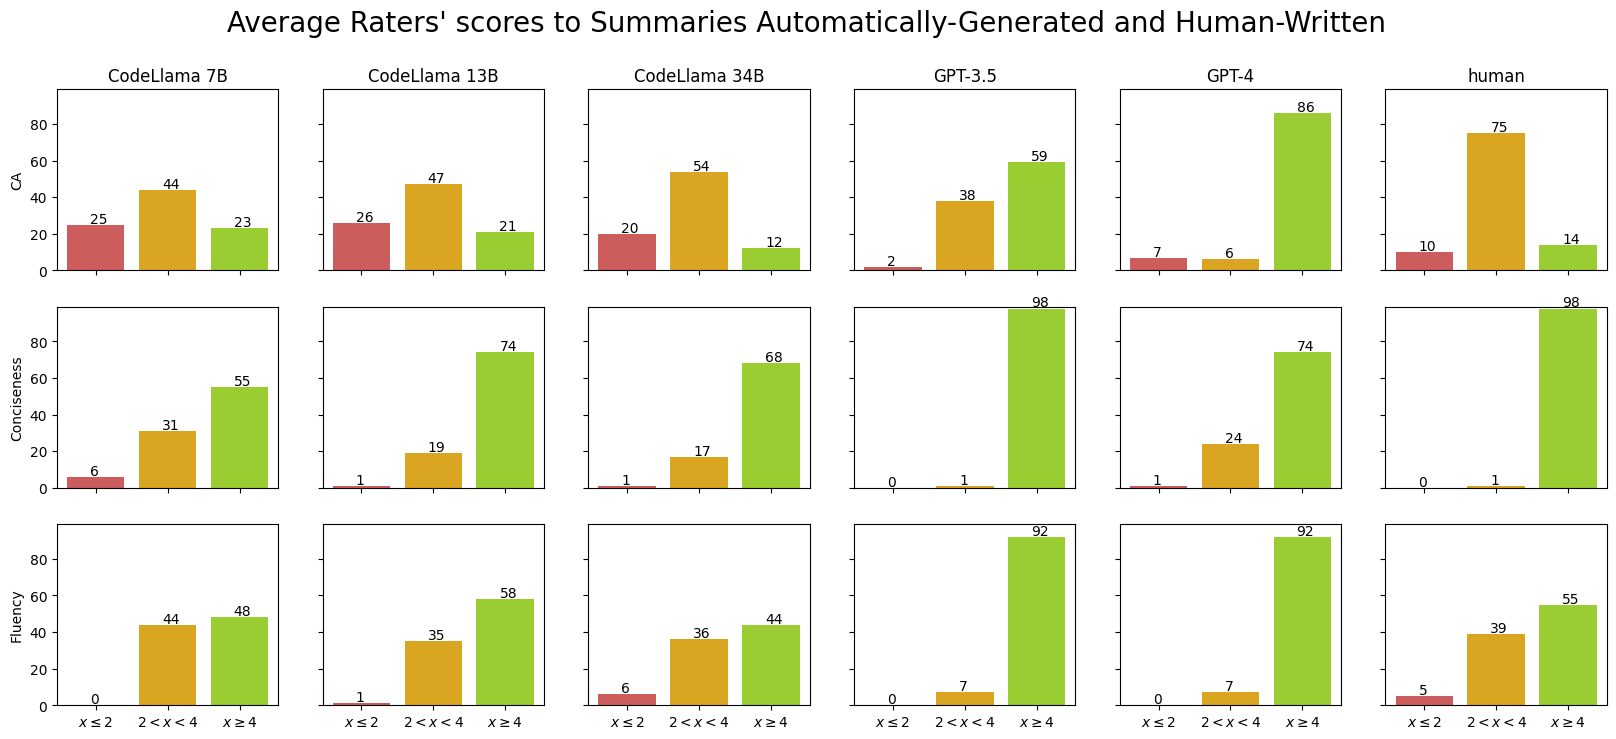

In [48]:
g.index = g.generated_by
g = g.reindex(index = ['CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo', 'human_written'])
n_rows = len(ASPECTS)
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, sharex = True, sharey = True, figsize = (20,8))
fig.suptitle('Average Raters\' scores to Summaries Automatically-Generated and Human-Written', fontsize = 20)
for irow, aspect in enumerate(ASPECTS):
    for icol in range(n_cols):
        arr = np.array(g[f'{aspect}_mean'].iloc[icol])
        arr = arr[np.where(arr > 0)]
        height = [arr[np.where(arr <= 2)].shape[0], \
                        arr[np.where(np.logical_and(arr > 2, arr < 4))].shape[0], \
                        arr[np.where(arr >= 4)].shape[0]]
        xs = [0,1,2]
        axs[irow, icol].bar(x = xs, height = height, color = ['indianred', 'goldenrod', 'yellowgreen'], \
                            tick_label = ['$x\leq 2$', '$2<x<4$', '$x\geq 4$'])
        
        axs[irow, icol].set_title(NAME_MAP[g.generated_by.iloc[icol]]) if irow == 0 else axs[irow, icol].set_title('')
        axs[irow, icol].set_ylabel(aspect) if icol == 0 else axs[irow, icol].set_ylabel('')
        axs[irow, icol].set_ylim(0,int(csdf.shape[0]/6) + 5)

        for i, v in enumerate(height):
            axs[irow, icol].text(xs[i] - 0.08, v + 1, str(v))
plt.show()

# Scatterplots

In [49]:
def count_grid_size(df):
    d = {}
    for human_x in range(1,6):
        for llm_y in range(1,6):
            count = df.loc[(df[df.columns[0]] == human_x) & (df[df.columns[1]] == llm_y)].shape[0]
            d.setdefault(f'[{human_x}, {llm_y}]', count)
    return d

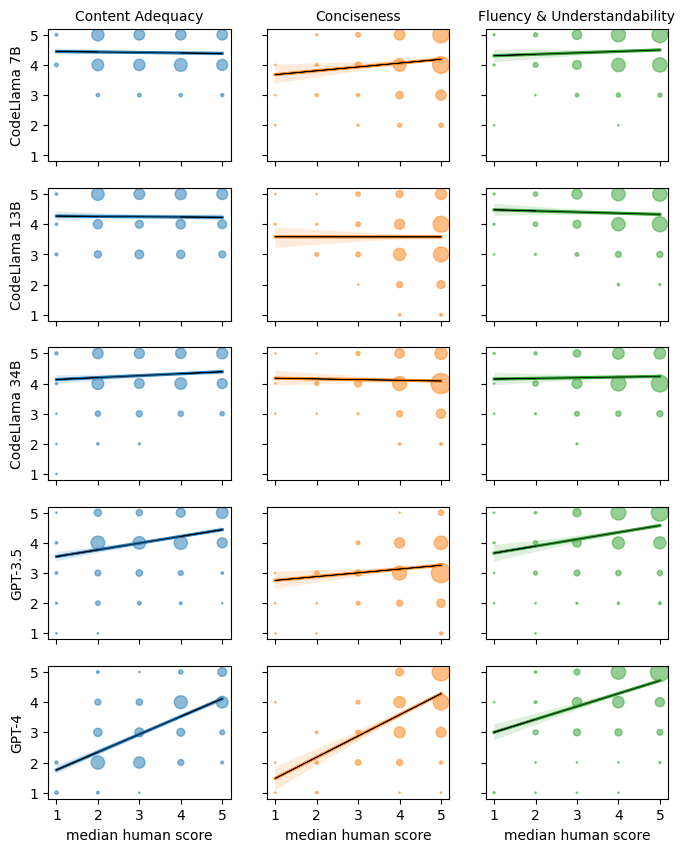

In [50]:
color_dict = {
    'CA' : plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
    'Conciseness' : plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
    'Fluency' : plt.rcParams['axes.prop_cycle'].by_key()['color'][2],
}

num_rows, num_cols = len(MODEL_NAMES), len(ASPECTS)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (8,10), sharex = True, sharey = True)

for row, model in enumerate(MODEL_NAMES):
    for col, aspect in enumerate(ASPECTS):
        to_scatter = csdf.loc[csdf[f'{model}_{aspect}'] > 0]
        x, y = to_scatter[f'{aspect}_median'], to_scatter[f'{model}_{aspect}']
        m, b = np.polyfit(x, y, 1)
        #add linear regression line to scatterplot
        sns.regplot(x = x, y = y, ax = axs[row, col], color = color_dict[aspect], scatter_kws={'s' : 0}).set(title = '')
        axs[row, col].plot(x, m*x+b, color = 'k', linewidth = .5)

        # add marker size
        markersize_dict = count_grid_size(to_scatter[[f'{aspect}_median', f'{model}_{aspect}']])
        axs[row, col].scatter([1,1,1,1,1, 2,2,2,2,2, 3,3,3,3,3, 4,4,4,4,4, 5,5,5,5,5], [1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5], \
                              s = np.array(list(markersize_dict.values())), alpha = .5, color = color_dict[aspect])
        
        if row == num_rows - 1:
            axs[row, col].set_xlabel('median human score')
            axs[row, col].set_xticks([1,2,3,4,5])
        else:
            axs[row, col].set_xlabel('')

        if col == 0:
            axs[row, col].set_yticks([1,2,3,4,5])
            axs[row, col].set_ylabel(f'{NAME_MAP[MODEL_NAMES[row]]}')
        else:
            axs[row, col].set_ylabel('')
        if row == 0:
            axs[row, col].set_title(ASPECTS_NAMES[aspect], fontsize = 10)
        else:
            axs[row, col].set_title('')
        
        # print(model, aspect)
        # print(markersize_dict)

# Kippendorf agreement
### predicted values and human evaluations

In [ ]:
# export model ratings vs median of human ratings to evaluate Kippendorf agreement
for model in MODEL_NAMES:
    for aspect in ASPECTS:
        df = csdf[[f'{model}_{aspect}', f'{aspect}_median']]
        df = df.loc[~(df == 0).any(axis = 1)] # drop row if any columns contains a zero
        df.to_csv(f'./llm_vs_human_{model}_{aspect}.csv', header = None, index = False)


# Self-bias

In [ ]:
def selfbias_difference(aspect):
    candidates = MODEL_NAMES + ['human_written']
    rating_cols = [f'{model}_{aspect}' for model in MODEL_NAMES]
    battle_ship = np.zeros((len(rating_cols), len(candidates)))

    for irow, judge in enumerate(rating_cols):
        for icol, candidate in enumerate(candidates):
            temp = csdf.loc[(csdf.generated_by == candidate) & (csdf[judge] > 0)] # select only successful judgments
            battle_ship[irow, icol] = (temp[judge] - temp[f'{aspect}_median']).sum() / temp.shape[0]

    d = {k : v for k, v in zip(rating_cols, battle_ship)}
    df = pd.DataFrame(d).T
    df.columns = candidates
    print(df.to_latex(index = True, float_format = "{:.2f}".format, caption = aspect))
    return df

In [ ]:
df = selfbias_difference('CA')
df = selfbias_difference('Conciseness')
df = selfbias_difference('Fluency')

\begin{table}
\caption{CA}
\begin{tabular}{lrrrrrr}
\toprule
 & CodeLlama-7b-Instruct-hf & CodeLlama-13b-Instruct-hf & CodeLlama-34b-Instruct-hf & gpt-3.5-turbo & gpt-4-turbo & human_written \\
\midrule
CodeLlama-7b-Instruct-hf_CA & 1.48 & 1.36 & 1.55 & 0.44 & -0.15 & 1.53 \\
CodeLlama-13b-Instruct-hf_CA & 1.32 & 1.08 & 1.29 & 0.32 & -0.21 & 1.40 \\
CodeLlama-34b-Instruct-hf_CA & 1.47 & 1.09 & 1.45 & 0.31 & -0.11 & 1.30 \\
gpt-3.5-turbo_CA & 1.17 & 0.85 & 0.98 & 0.33 & 0.11 & 0.75 \\
gpt-4-turbo_CA & -0.09 & -0.35 & -0.28 & -0.05 & -0.13 & -0.46 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Conciseness}
\begin{tabular}{lrrrrrr}
\toprule
 & CodeLlama-7b-Instruct-hf & CodeLlama-13b-Instruct-hf & CodeLlama-34b-Instruct-hf & gpt-3.5-turbo & gpt-4-turbo & human_written \\
\midrule
CodeLlama-7b-Instruct-hf_Conciseness & 0.22 & -0.36 & -0.48 & -0.69 & -0.20 & -0.67 \\
CodeLlama-13b-Instruct-hf_Conciseness & -0.39 & -0.89 & -0.80 & -1.37 & -0.78 & -1.19 \\
CodeLlama-34b-Inst

# Statistical tests

In [ ]:
# write csv for R analysis
# P-VALUE LLM 
# - self judgement VS judgement of all other LLMs
# - self judgement VS judgement of all other LLMs not belonging to the same family
# - self judgement VS judgement of human witten functions

csdf.generated_by = csdf.generated_by.apply(lambda x : x.replace('codellama/', ''))

for model in MODEL_NAMES:
    for aspect in ASPECTS:
        col = f'{model}_{aspect}'
        temp = csdf.loc[csdf[col] > 0][['generated_by', col, f'{aspect}_median']]
        family_name = col.split('-')[0]

        t = temp.loc[temp.generated_by == model]
        itsown = np.array(t[col] - t[f'{aspect}_median']) # ratings given by the judge model to the summaries generated by the judge model itself
        
        t = temp.loc[(~temp.generated_by.str.contains(family_name)) & (temp.generated_by != 'human_written')]
        all_but_family = np.array(t[col] - t[f'{aspect}_median']) # ratings given by the judge model to the summaries generated by all the LLMs not belonging to its family (ie, Codellama, ChatGPT)
        
        t = temp.loc[(temp.generated_by != model) & (temp.generated_by != 'human_written')]
        all_others = np.array(t[col] - t[f'{aspect}_median']) # ratings given by the judge model to the summaries generated by all the other LLMs
        
        t = temp.loc[temp.generated_by == 'human_written']
        human = np.array(t[col] - t[f'{aspect}_median']) # ratings given by the judge model to the summaries written by humans
        while itsown.shape[0] < all_others.shape[0]:
            itsown = np.concatenate((itsown, np.array([np.nan])))
        while all_but_family.shape[0] < all_others.shape[0]:
            all_but_family = np.concatenate((all_but_family, np.array([np.nan])))
        while human.shape[0] < all_others.shape[0]:
            human = np.concatenate((human, np.array([np.nan])))
        
        pd.DataFrame({
            'Model' : itsown,
            'all_LLM' : all_others,
            'all_Minus' : all_but_family,
            'humans' : human
        }).to_csv(f'./{model}_{aspect}.csv', index = False)